### SlideCNA

#### HTAPP-895-SMP-7359

In [10]:
# Set paths to data and results
path_to_data <- "path/to/data/" 
path_to_results <- "path/to/results/"

In [11]:
libraries <- c("ggplot2", "Seurat", "glue", "dplyr", "anndata", "spacexr", 
               "data.table", "Matrix", "mltools", "enrichR", "R.utils")
lapply(libraries, function(x) suppressMessages(require(x, character.only = TRUE,quietly=TRUE,warn.conflicts = FALSE)))

[[1]]
[1] TRUE

[[2]]
[1] TRUE

[[3]]
[1] TRUE

[[4]]
[1] TRUE

[[5]]
[1] TRUE

[[6]]
[1] TRUE

[[7]]
[1] TRUE

[[8]]
[1] TRUE

[[9]]
[1] TRUE

[[10]]
[1] TRUE

[[11]]
[1] TRUE

In [12]:
sample <- "HTAPP-895-SMP-7359"

In [13]:
# Assumes you're working in the repository root directory
source("code/utils.R")

In [14]:
# Uncomment below to use reticulate to set the conda environment

#library(reticulate)
#use_condaenv(condaenv = "SlideCNA_env") #if error, set conda environment manually for reticulate

In [15]:
# Inputs needed:
# Slide-seq: 
#  counts
#  annotated beads with bead label, cluster type (Malignant, Non-malignant), 
#     and spatial coordinates of each bead (pos_x, pos_y)
#  position of genes on chromosomes 

In [ ]:
# Read inputs
counts <- read.table(paste0(path_to_data, sample, "_slide-seq_counts.txt"), check.names = FALSE)
beads_df <- read.table(paste0(path_to_data, sample, "_slide-seq_beads_annotated.txt"))
gene_pos <- read.table(paste0(path_to_data, "gene_pos.txt"))

In [9]:
counts[1:5,1:5]
dim(counts)

,TCATATACTGTTGT-1,TACTTTCAGGACTG-1,AACCCAAGTTAGGG-1,ACTCAGGCCTCCAC-1,TTCGCTCCACACTT-1
,<int>,<int>,<int>,<int>,<int>
A1BG,0,0,0,0,0
A1BG-AS1,0,0,0,0,0
A2M,0,0,1,0,2
A2M-AS1,0,0,0,0,0
A2ML1,0,0,0,0,0


[1] 18107  6210

In [10]:
head(beads_df)
dim(beads_df)

,bc,x_orig,y_orig,replicate,n_counts,n_genes,pos_x,pos_y,n_genes_by_counts,total_counts,total_counts_mt,pct_counts_mt,leiden,cell_type,cluster_type
,<chr>,<dbl>,<dbl>,<int>,<int>,<int>,<dbl>,<dbl>,<int>,<int>,<int>,<dbl>,<int>,<chr>,<chr>
AAAAACCTGAGAGT-1,AAAAACCTGAGAGT-1,1427.94,1695.18,1,239,181,621.8775,1281.990,181,239,10,4.184101,1,MBC,Malignant
AAAAAGCCACTTAT-1,AAAAAGCCACTTAT-1,1495.14,1830.06,1,278,231,518.1788,1172.651,231,278,18,6.474820,0,MBC,Malignant
AAAACACGAAGTCC-1,AAAACACGAAGTCC-1,446.82,1154.76,1,814,569,1718.1308,1511.945,569,814,30,3.685504,0,MBC,Malignant
AAAACCGACTATAA-1,AAAACCGACTATAA-1,1426.56,1544.64,1,162,140,667.2109,1425.549,140,162,3,1.851852,1,MBC,Malignant
AAAACCGCACGAGC-1,AAAACCGCACGAGC-1,635.76,1141.26,1,1062,721,1541.3936,1580.096,720,1062,18,1.694915,0,MBC,Malignant
AAAACGATGAATAT-1,AAAACGATGAATAT-1,475.80,1207.26,1,313,240,1675.0676,1470.212,240,313,28,8.945687,2,MBC,Malignant


[1] 5220   15

In [11]:
# Reformat counts dataframe

In [12]:
counts <- counts %>% select(beads_df$bc)
counts_mat <- counts %>% as.data.table() %>% sparsify()
row.names(counts_mat) <- row.names(counts)

In [13]:
# Plot distribution of marker genes over space

In [14]:
counts$GENE <- row.names(counts)
counts_long=reshape2::melt(counts,id.vars = "GENE")
counts_long = as.data.table(counts_long)
counts_long <- counts_long[counts_long$value!=0]

In [15]:
counts_long=merge(counts_long,beads_df,by.x="variable",by.y="bc",all.x=TRUE)
head(counts_long)

variable,GENE,value,x_orig,y_orig,replicate,n_counts,n_genes,pos_x,pos_y,n_genes_by_counts,total_counts,total_counts_mt,pct_counts_mt,leiden,cell_type,cluster_type
<chr>,<chr>,<int>,<dbl>,<dbl>,<int>,<int>,<int>,<dbl>,<dbl>,<int>,<int>,<int>,<dbl>,<int>,<chr>,<chr>
AAAAACCTGAGAGT-1,ACADM,1,1427.94,1695.18,1,239,181,621.8775,1281.99,181,239,10,4.184101,1,MBC,Malignant
AAAAACCTGAGAGT-1,ACTG1,1,1427.94,1695.18,1,239,181,621.8775,1281.99,181,239,10,4.184101,1,MBC,Malignant
AAAAACCTGAGAGT-1,ADAP2,1,1427.94,1695.18,1,239,181,621.8775,1281.99,181,239,10,4.184101,1,MBC,Malignant
AAAAACCTGAGAGT-1,AFTPH,1,1427.94,1695.18,1,239,181,621.8775,1281.99,181,239,10,4.184101,1,MBC,Malignant
AAAAACCTGAGAGT-1,APBB2,1,1427.94,1695.18,1,239,181,621.8775,1281.99,181,239,10,4.184101,1,MBC,Malignant
AAAAACCTGAGAGT-1,ARMC1,1,1427.94,1695.18,1,239,181,621.8775,1281.99,181,239,10,4.184101,1,MBC,Malignant


In [16]:
summary(counts_long[,sum(value),by=c("pos_x","pos_y")]$V1)
summary(counts_long[,sum(value!=0),by=c("pos_x","pos_y")]$V1)
length(unique(counts_long$variable))

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  100.0   244.0   491.5   711.1   943.0  7112.0 

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
   47.0   189.8   356.0   467.7   628.0  3107.0 

[1] 5220

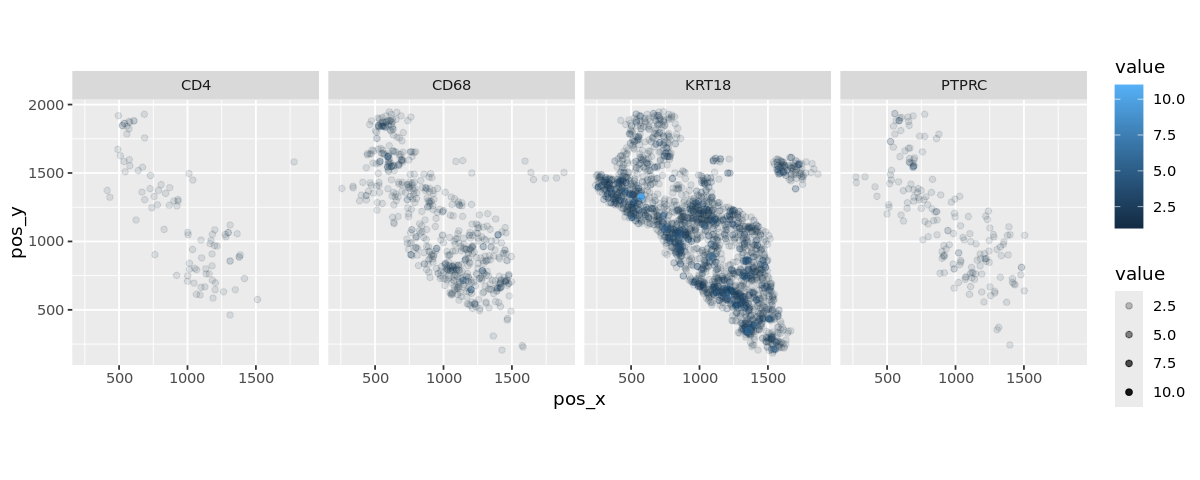

In [17]:
options(repr.plot.width = 10, repr.plot.height =4)
ggplot(counts_long[GENE%in%c("KRT18","CD4","CD68","PTPRC")],aes(x=pos_x,y=pos_y))+geom_point(aes(col=value,alpha=value))+coord_fixed()+facet_grid(~GENE)

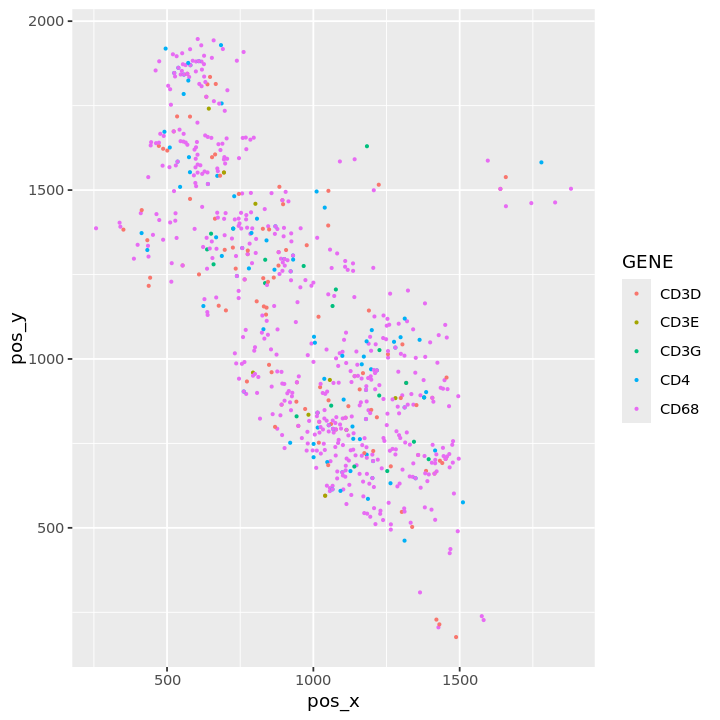

In [18]:
options(repr.plot.width = 6, repr.plot.height =6)
ggplot(counts_long[GENE%in%c("CD3E","CD3D","CD3G","CD3A","CD3B","CD4","CD68","CD56")],aes(x=pos_x,y=pos_y))+geom_point(aes(col=GENE),size=0.5)

#### Run SlideCNA

In [19]:
library(SlideCNA)


Attaching package: 'SlideCNA'


The following object is masked from 'package:Seurat':

    SpatialPlot


The following object is masked from 'package:base':

    mode




In [7]:
output_directory <- file.path(path_to_results, "SlideCNA")
plot_directory <- file.path(output_directory, "plots")
dir.create(output_directory, showWarnings = FALSE)
dir.create(plot_directory, showWarnings = FALSE)

Warning message:
"Feature names cannot have underscores ('_'), replacing with dashes ('-')"
Warning message:
"Feature names cannot have underscores ('_'), replacing with dashes ('-')"
Regressing out nCount_RNA, percent.mito

Centering and scaling data matrix

PC_ 1 
Positive:  TFF1, AGR2, NDRG1, DHRS2, DSP, MAL2, EPCAM, STC2, TOP2A, BHLHE40 
	   CRISPLD1, RP11-206M11.7, HILPDA, DDIT3, MAGEA1, MLPH, CDK1, CCDC34, IER3, H19 
	   PITX1, PEG10, GALNT7, ZMYND8, GOLM1, AP1M2, FBXO32, MUCL1, CENPF, CENPA 
Negative:  IGHG4, IGHG3, IGKC, IGHG1, IGLC2, IGHG2, CD74, AC096579.7, HLA-DRA, IGLC7 
	   IGHM, IGLC3, APOE, HLA-DRB1, IGLL5, MZB1, CTSB, SPARC, HLA-DPB1, COL3A1 
	   IGJ, IGFBP7, C1QB, IGHA1, COL1A2, LYZ, TAGLN, APOC1, IGLV3-1, CTSZ 
PC_ 2 
Positive:  IGLC7, IGJ, IGHG2, IGLC3, IGLV6-57, IGHA1, MZB1, IGLC2, AC096579.7, IGLL5 
	   IGHG3, IGLV1-40, IGHG1, IGHD, IGHG4, IGKC, IGLV3-1, IGLJ3, PIM2, SLAMF7 
	   IGLV3-10, IGLV1-51, EAF2, IGLJ2, IGLV2-14, IGHM, CDKN1A, IGHA2, GLRX, IGLV2-8 
Negative

Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 5220
Number of edges: 159826

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.6842
Number of communities: 8
Elapsed time: 0 seconds


Warning message:
"The default method for RunUMAP has changed from calling Python UMAP via reticulate to the R-native UWOT using the cosine metric
To use Python UMAP via reticulate, set umap.method to 'umap-learn' and metric to 'correlation'
This message will be shown once per session"
19:04:11 UMAP embedding parameters a = 0.9922 b = 1.112

19:04:11 Read 5220 rows and found 10 numeric columns

19:04:11 Using Annoy for neighbor search, n_neighbors = 30

19:04:11 Building Annoy index with metric = cosine, n_trees = 50

0%   10   20   30   40   50   60   70   80   90   100%

[----|----|----|----|----|----|----|----|----|----|

*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
|

19:04:12 Writing NN index file to temp file /local/scratch/47642484.1.interactive/RtmpKJFWnP/file257b34c61bebd

19:04:12 Searching Annoy index using 1 thread, search_k = 3000

19:04:15 Annoy recall = 100%

19:04:16 Commencing smooth kNN distance calibration using 1

Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 435
Number of edges: 17595

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.5690
Number of communities: 4
Elapsed time: 0 seconds


20:04:11 UMAP embedding parameters a = 0.9922 b = 1.112

20:04:11 Read 435 rows and found 10 numeric columns

20:04:11 Using Annoy for neighbor search, n_neighbors = 30

20:04:11 Building Annoy index with metric = cosine, n_trees = 50

0%   10   20   30   40   50   60   70   80   90   100%

[----|----|----|----|----|----|----|----|----|----|

*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
|

20:04:11 Writing NN index file to temp file /local/scratch/47642484.1.interactive/RtmpKJFWnP/file257b3239c74fd

20:04:11 Searching Annoy index using 1 thread, search_k = 3000

20:04:11 Annoy recall = 100%

20:04:12 Commencing smooth kNN distance calibration using 1 thread
 with target n_neighbors = 30

20:04:15 Initializing from normalized Laplacian + noise (using irlba)

20:04:15 Commencing optimization for 500 epochs, with 17412 positive edges

20:04:18 Optimization finished

Regressing out nCount_RNA, percent.mito

Centering and scaling data m

Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 435
Number of edges: 17595

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.5690
Number of communities: 4
Elapsed time: 0 seconds


20:05:28 UMAP embedding parameters a = 0.9922 b = 1.112

20:05:28 Read 435 rows and found 10 numeric columns

20:05:28 Using Annoy for neighbor search, n_neighbors = 30

20:05:28 Building Annoy index with metric = cosine, n_trees = 50

0%   10   20   30   40   50   60   70   80   90   100%

[----|----|----|----|----|----|----|----|----|----|

*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
|

20:05:28 Writing NN index file to temp file /local/scratch/47642484.1.interactive/RtmpKJFWnP/file257b319a12dce

20:05:28 Searching Annoy index using 1 thread, search_k = 3000

20:05:28 Annoy recall = 100%

20:05:29 Commencing smooth kNN distance calibration using 1 thread
 with target n_neighbors = 30

20:05:31 Initializing from normalized Laplacian + noise (using irlba)

20:05:31 Commencing optimization for 500 epochs, with 17412 positive edges

20:05:35 Optimization finished

Calculating cluster 1

Calculating cluster 2

Calculating cluster 3



Uploading data to Enrichr... Done.
  Querying GO_Biological_Process_2018... Done.
Parsing results... Done.
Uploading data to Enrichr... Done.
  Querying GO_Biological_Process_2018... Done.
Parsing results... Done.


Regressing out nCount_RNA, percent.mito

Centering and scaling data matrix

PC_ 1 
Positive:  IGHG4, IGHG3, IGHG1, IGKC, IGLC2, HLA-B, HLA-DRA, CD74, AC096579.7, IGHG2 
	   COL3A1, SPARC, C1QB, CTSB, COL1A2, APOE, IGFBP7, HLA-DPB1, C1QA, HLA-DRB1 
	   C1QC, CALD1, COL1A1, VIM, IGLL5, FN1, HLA-C, TAGLN, IGLC7, IGHM 
Negative:  TFF1, TFF3, ADIRF, TM4SF1, LDHA, GSTM3, NDRG1, TTTY14, AGR2, DHRS2 
	   ANAPC11, BHLHE40, MPHOSPH6, CLDN4, DNAJB1, IGFBP4, ATP6V0B, SLC2A1, FHL2, ARL6IP1 
	   SUSD3, HIST1H1C, HSPA1A, H1F0, BAMBI, STARD10, MYEOV2, HIST1H2BD, C17orf58, HSPE1 
PC_ 2 
Positive:  COL1A1, COL1A2, COL6A3, COL4A1, MMP11, TIMP3, COL4A2, SPARC, HOPX, CTHRC1 
	   IGFBP7, BGN, ISLR, RARRES2, COL3A1, CALD1, FN1, VCAN, AEBP1, ACTA2 
	   THBS2, ACTG2, MMP14, RGS5, POSTN, GREM1, FSTL1, COL5A2, LDHA, ANTXR1 
Negative:  IGHD, IGHA1, IGJ, IGHG1, IGLC7, IGHG4, IGLV2-14, IGKC, IGLV6-57, IGHG3 
	   AC096579.7, DERL3, IGHG2, SAA1, APOE, CXCL14, HLA-DRB1, IGLL5, AC092071.1, MZB1 
	   IGLJ3, LYZ, HBB, LL

Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 372
Number of edges: 16441

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.5454
Number of communities: 3
Elapsed time: 0 seconds


20:10:12 UMAP embedding parameters a = 0.9922 b = 1.112

20:10:12 Read 372 rows and found 10 numeric columns

20:10:12 Using Annoy for neighbor search, n_neighbors = 30

20:10:12 Building Annoy index with metric = cosine, n_trees = 50

0%   10   20   30   40   50   60   70   80   90   100%

[----|----|----|----|----|----|----|----|----|----|

*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
|

20:10:12 Writing NN index file to temp file /local/scratch/47642484.1.interactive/RtmpKJFWnP/file257b310ed16c3

20:10:12 Searching Annoy index using 1 thread, search_k = 3000

20:10:12 Annoy recall = 100%

20:10:14 Commencing smooth kNN distance calibration using 1 thread
 with target n_neighbors = 30

20:10:16 Initializing from normalized Laplacian + noise (using irlba)

20:10:16 Commencing optimization for 500 epochs, with 14550 positive edges

20:10:19 Optimization finished

Regressing out nCount_RNA, percent.mito

Centering and scaling data m

Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 372
Number of edges: 16441

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.5454
Number of communities: 3
Elapsed time: 0 seconds


20:11:25 UMAP embedding parameters a = 0.9922 b = 1.112

20:11:25 Read 372 rows and found 10 numeric columns

20:11:25 Using Annoy for neighbor search, n_neighbors = 30

20:11:25 Building Annoy index with metric = cosine, n_trees = 50

0%   10   20   30   40   50   60   70   80   90   100%

[----|----|----|----|----|----|----|----|----|----|

*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
|

20:11:25 Writing NN index file to temp file /local/scratch/47642484.1.interactive/RtmpKJFWnP/file257b36726fb6d

20:11:25 Searching Annoy index using 1 thread, search_k = 3000

20:11:25 Annoy recall = 100%

20:11:27 Commencing smooth kNN distance calibration using 1 thread
 with target n_neighbors = 30

20:11:29 Initializing from normalized Laplacian + noise (using irlba)

20:11:29 Commencing optimization for 500 epochs, with 14550 positive edges

20:11:32 Optimization finished

Calculating cluster 1

Calculating cluster 2



Uploading data to Enrichr... Done.
  Querying GO_Biological_Process_2018... Done.
Parsing results... Done.
Uploading data to Enrichr... Done.
  Querying GO_Biological_Process_2018... Done.
Parsing results... Done.


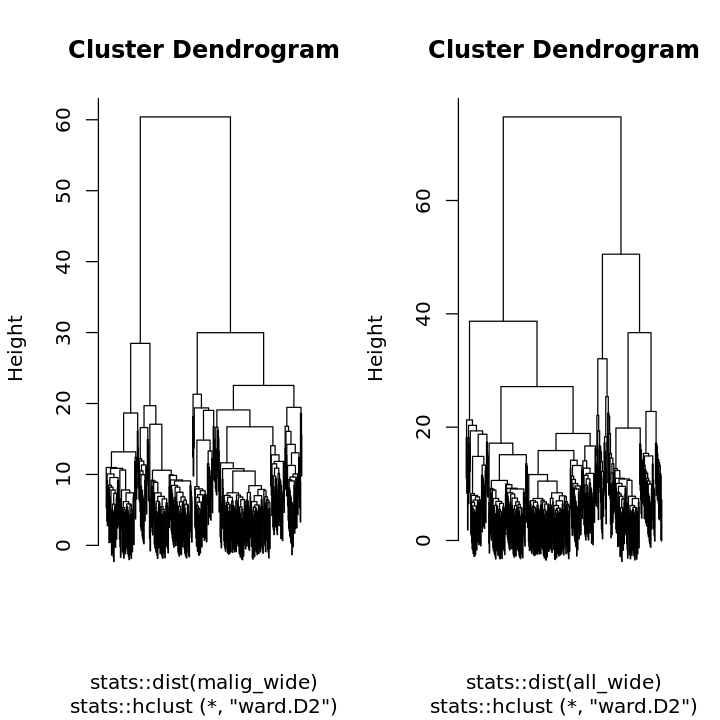

In [24]:
run_slide_cna(counts, 
              beads_df, 
              gene_pos,
              output_directory,
              plot_directory,
              spatial=TRUE)

#### Analyze Seurat Object of Slide-seq data

In [40]:
so <- readRDS(file=file.path(output_directory, "so.rds"))
md <- read.table(file=file.path(output_directory, "md_bin.txt"))

In [41]:
# TSNE Plots

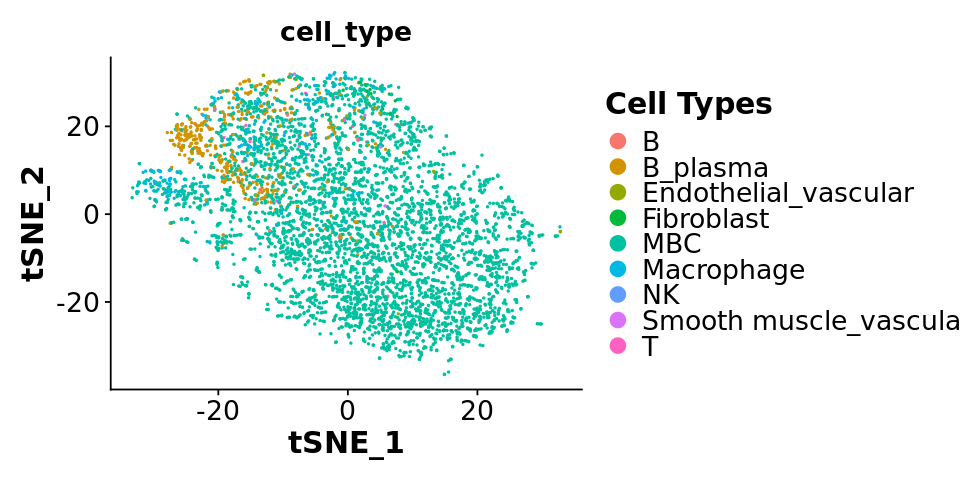

In [42]:
legend_title = "Cell Types"
options(repr.plot.width = 8, repr.plot.height = 4)
TSNEPlot(so, label.size = 18, group.by="cell_type") +
    theme(axis.text=element_text(size=text_size), axis.title=element_text(size=title_size, face='bold'),
          legend.title=element_text(size=title_size, face='bold'), legend.text=element_text(size=text_size)) +
    labs(color = legend_title) +
    guides(color = guide_legend(override.aes = list(size = legend_size_pt)))

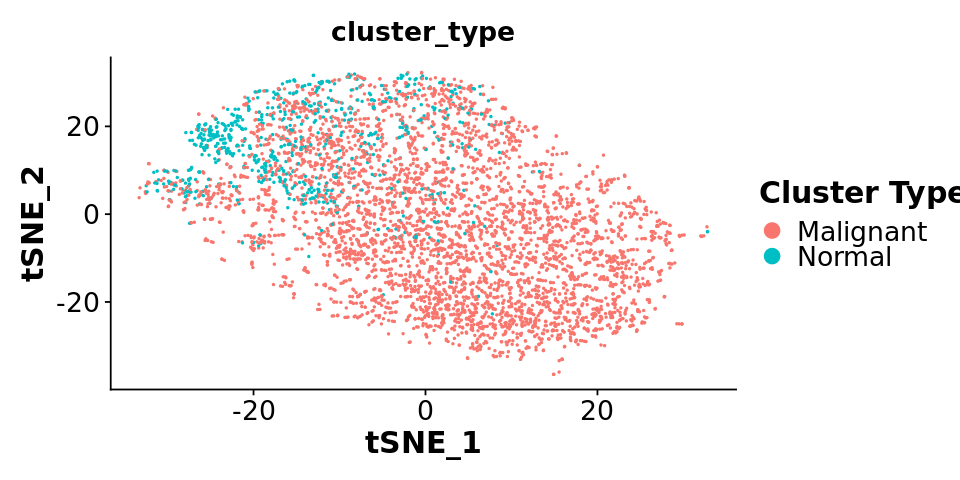

In [43]:
legend_title = "Cluster Type"
options(repr.plot.width = 8, repr.plot.height =4)
TSNEPlot(so, label.size = 18, group.by="cluster_type") +
    theme(axis.text=element_text(size=text_size), axis.title=element_text(size=title_size, face='bold'),
          legend.title=element_text(size=title_size, face='bold'), legend.text=element_text(size=text_size)) +
    labs(color = legend_title) +
    guides(color = guide_legend(override.aes = list(size = legend_size_pt)))

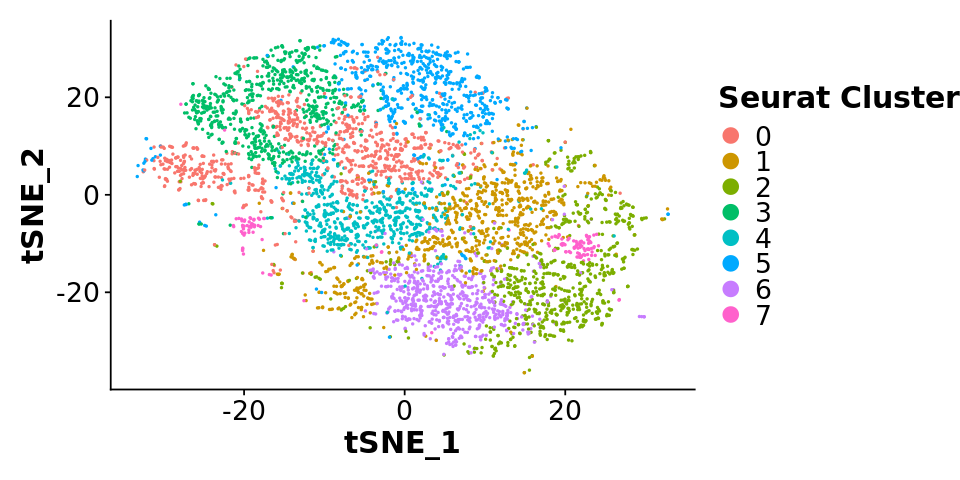

In [44]:
legend_title = "Seurat Clusters"
options(repr.plot.width = 8, repr.plot.height =4)
TSNEPlot(so, label.size = 18) +
    theme(axis.text=element_text(size=text_size), axis.title=element_text(size=title_size, face='bold'),
          legend.title=element_text(size=title_size, face='bold'), legend.text=element_text(size=text_size)) +
    labs(color = legend_title) +
    guides(color = guide_legend(override.aes = list(size = legend_size_pt)))

In [45]:
# Spatial plots

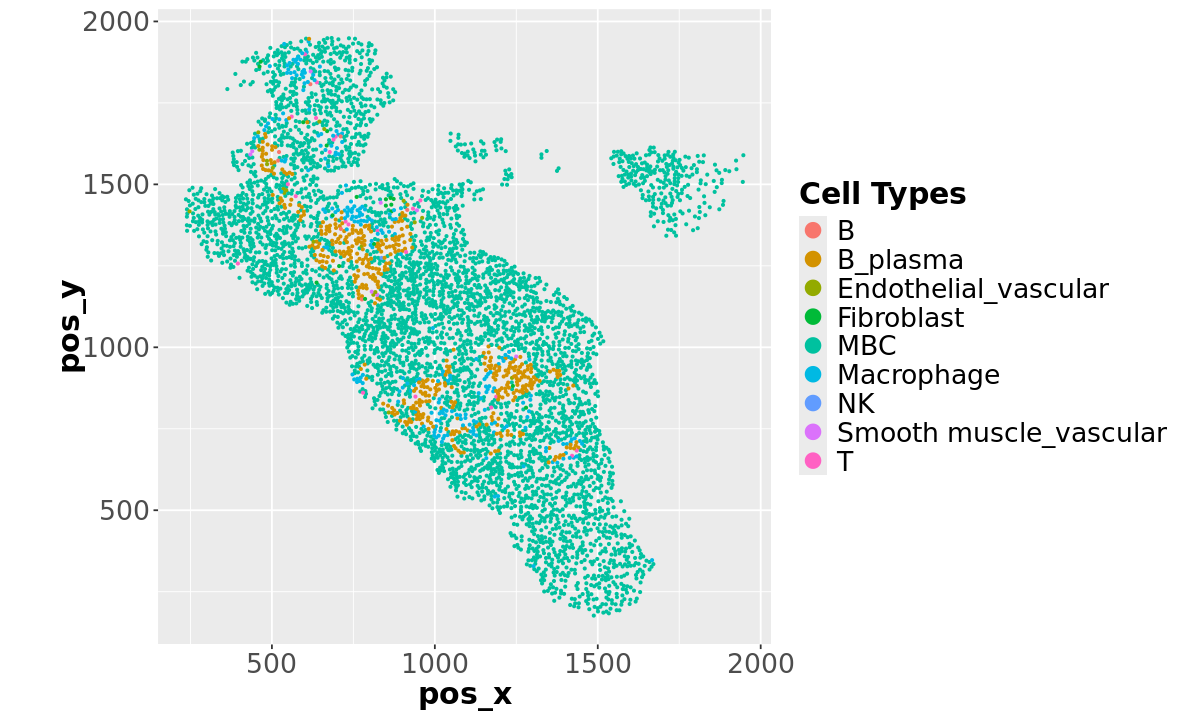

In [46]:
legend_title = "Cell Types"
options(repr.plot.width = 10, repr.plot.height = 6)
ggplot(md,aes(x=pos_x,y=pos_y,col=(cell_type)))+geom_point(size=0.5, position="jitter")+coord_fixed() +
    theme(axis.text=element_text(size=text_size), axis.title=element_text(size=title_size, face='bold'),
          legend.title=element_text(size=title_size, face='bold'), legend.text=element_text(size=text_size)) +
    labs(color = legend_title) +
    guides(color = guide_legend(override.aes = list(size = legend_size_pt)))

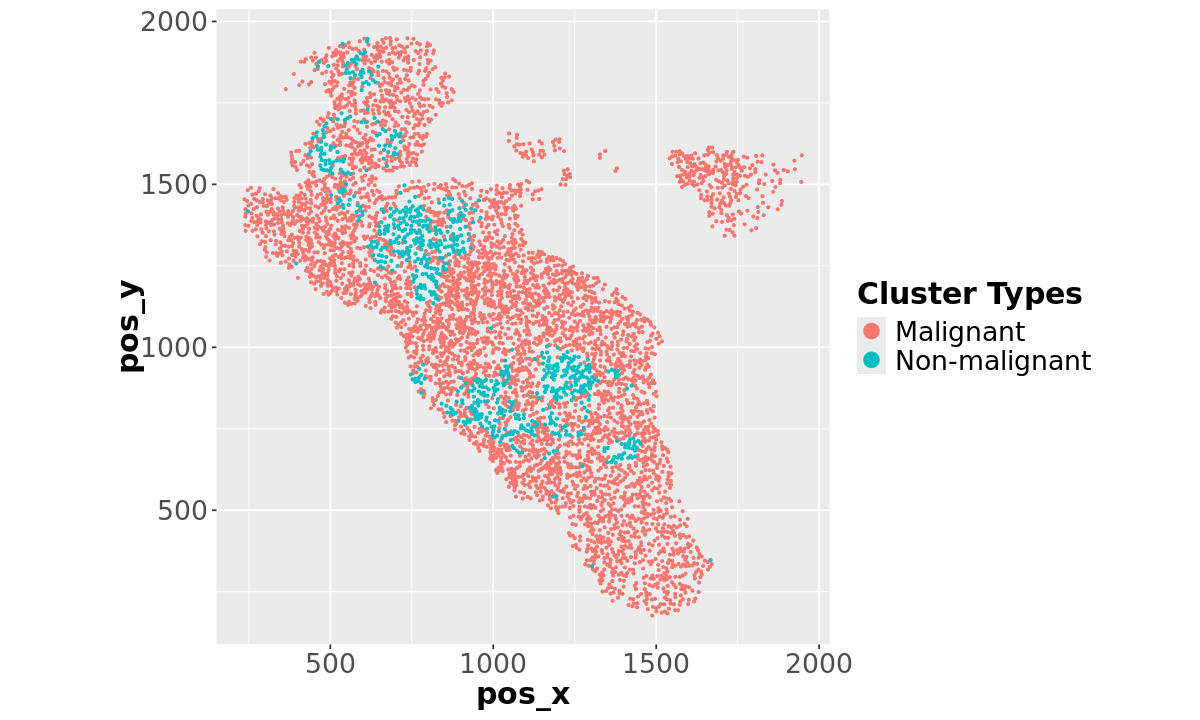

In [47]:
legend_title = "Cluster Types"
options(repr.plot.width = 10, repr.plot.height = 6)
ggplot(md,aes(x=pos_x,y=pos_y,col=(cluster_type)))+geom_point(size=0.5, position="jitter")+coord_fixed() +
    theme(axis.text=element_text(size=text_size), axis.title=element_text(size=title_size, face='bold'),
          legend.title=element_text(size=title_size, face='bold'), legend.text=element_text(size=text_size)) +
    labs(color = legend_title) +
    guides(color = guide_legend(override.aes = list(size = legend_size_pt)))

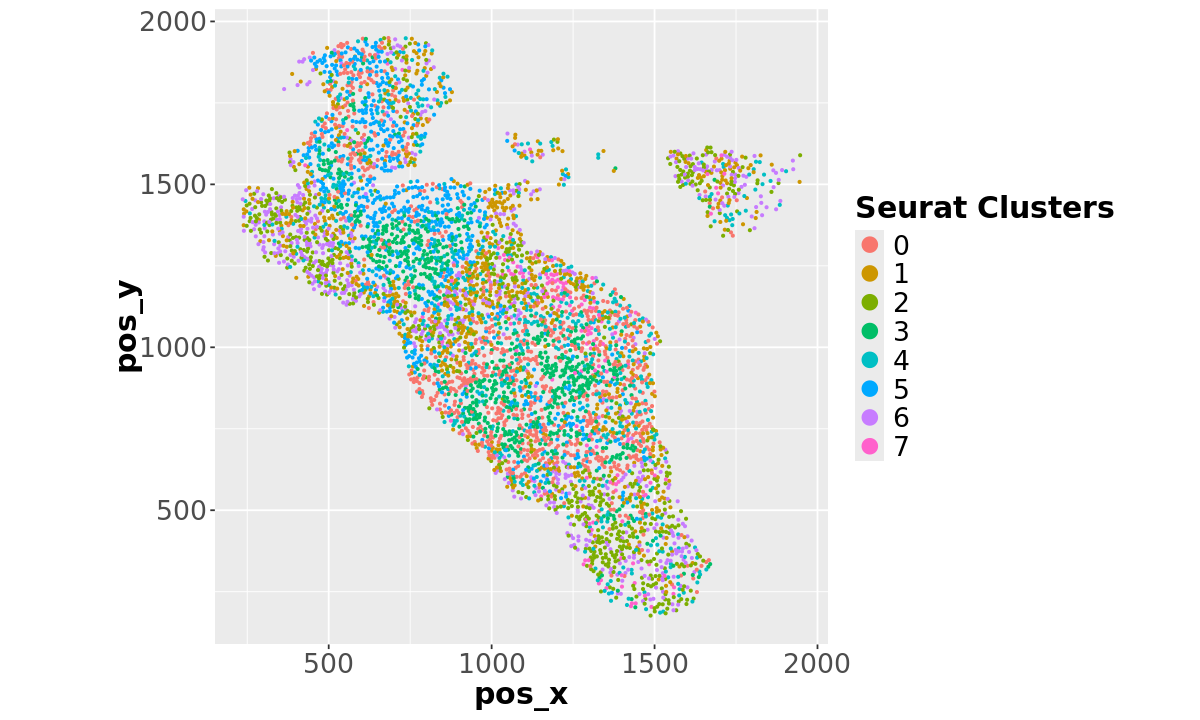

In [48]:
legend_title = "Seurat Clusters"
options(repr.plot.width = 10, repr.plot.height = 6)
ggplot(md,aes(x=pos_x,y=pos_y,col=as.factor(seurat_clusters)))+geom_point(size=0.5)+coord_fixed() +
    theme(axis.text=element_text(size=text_size), axis.title=element_text(size=title_size, face='bold'),
          legend.title=element_text(size=title_size, face='bold'), legend.text=element_text(size=text_size)) +
    labs(color = legend_title) +
    guides(color = guide_legend(override.aes = list(size = legend_size_pt)))

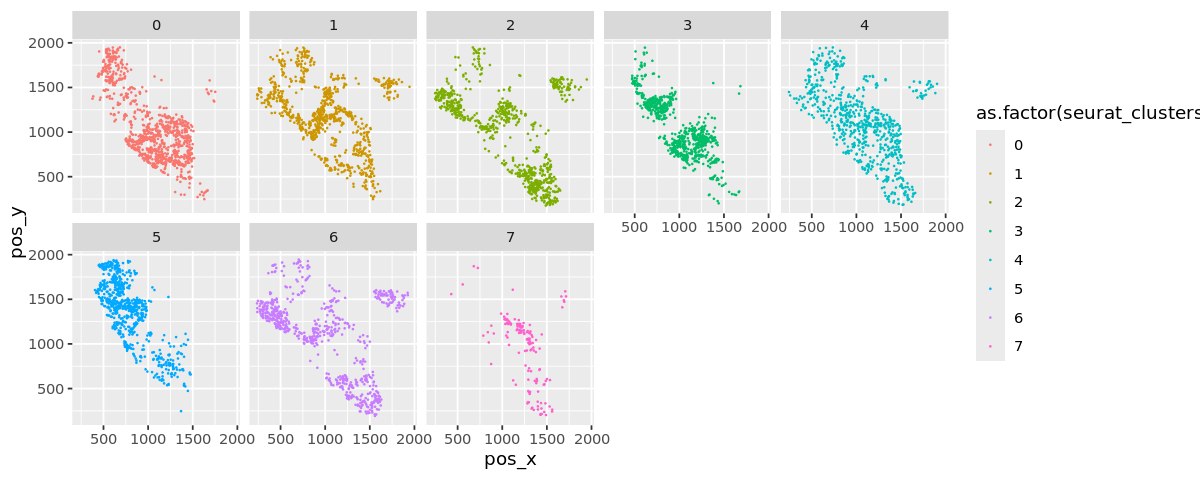

In [49]:
options(repr.plot.width = 10, repr.plot.height =4)
ggplot(md,aes(x=pos_x,y=pos_y,col=as.factor(seurat_clusters)))+geom_point(size=0.1)+coord_fixed()+facet_wrap(~seurat_clusters,ncol=5)